In [249]:
## setup analysis
import numpy as np
import cv2
from matplotlib import pyplot as plt
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
filename = r'D:\measuring\Labview\CCDcamera\Bitmarker_field_of_view.dat'
# filename = r'D:\measuring\Labview\CCDcamera\Bitmarker_and_stripline.dat'
%matplotlib inline
from itertools import compress

In [250]:
### apply a brightness filter we only want to detect bright features.
def apply_brightness_filter(array2d,threshold_min,threshold_max = 256):
    return array2d*(array2d>threshold_min)*(array2d<threshold_max)

### stamp out the central region of the image a.k.a. what is our field of view?
def stamp_out_relevant_field_of_view(array2d,xsize=300,ysize=300,xoffset = 10, yoffset = 60):
    """
    Slices an array according to given sizes.
    Input parameters with offset give an offset from the CENTRE of the array!
    """
    
    (xlen,ylen) =np.shape(array2d)

    xmin = int(xlen/2.-xsize/2.)+xoffset
    xmax = int(xlen/2.+xsize/2.)+xoffset
    ymin = int(ylen/2.-ysize/2.)+yoffset
    ymax = int(ylen/2.+ysize/2.)+yoffset

    return array2d[xmin:xmax,ymin:ymax] 

def make_brightness_hist(array2d, rng = (0,255)):
    """
    Makes a histogram according to the grayscale values of an array.
    assumes that the value range of the array is 0 to 255
    Excludes 0!
    """
    
    n,bins = np.histogram(array2d,bins=255,range=rng)
    fig = plt.figure()
    ax = plt.subplot()
    if 0 in x or 0.0 in x:
        np.indices(len(x))[x ==0]
    x = (bins[1:]-(bins[1]-bins[0])/2.)[1:] ### exclude 0
    plt.plot(x,n[1:]) ### exclude 0
    ax.set_xlabel('Pixel brightness')
    ax.set_ylabel('Occurences #')
    
    return x,n[1:]

def show_image(array2d,size = 7):
    fig = plt.figure(figsize = (size,size))
    ax = plt.subplot()
    im = plt.imshow(array2d,cmap='gray')
    fig.colorbar(im) 
    plt.show()
    plt.close('all')

def make_binary(array2d,threshold_min):
    return array2d>threshold_min


def rescale_to_8_bit_grayscale(img):
    """
    scales an image from 0 to 255.
    """
    img = np.abs(img)-(np.amin(np.abs(img))) ## set min to zero and scale to 255
    img = img*255/np.amax(img)
    return img.astype(np.uint8)
    
    
def compensate_brightness_gradient(array2d,gradient_step):
    pass

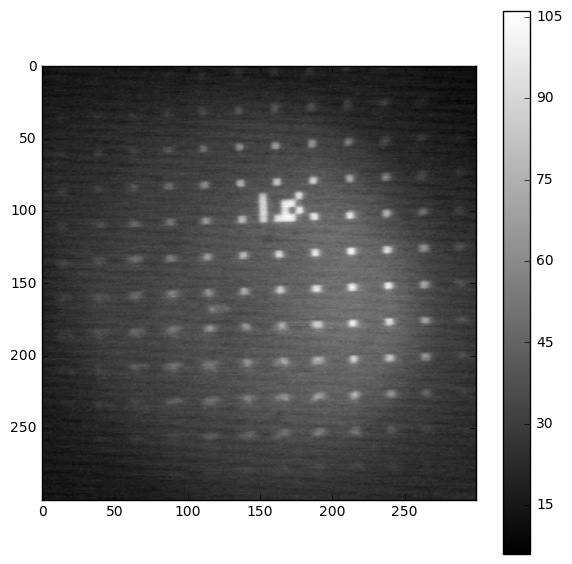

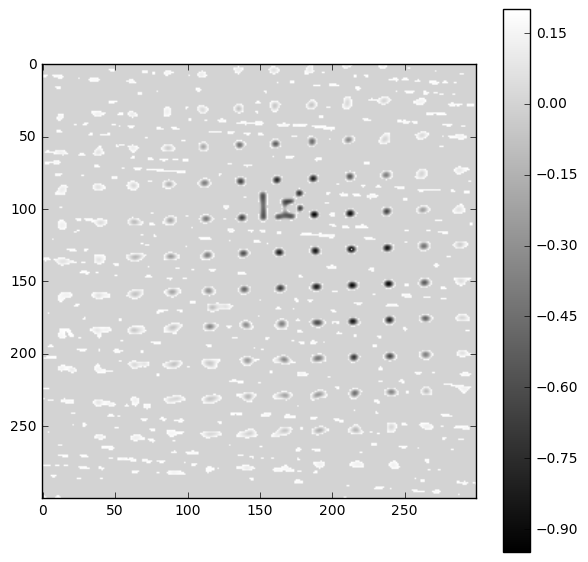

In [251]:
### do some fast image loading via numpy
array2d = np.loadtxt(filename,delimiter='\t',ndmin = 2)
# show_image(array2d)
array_prepared = stamp_out_relevant_field_of_view(apply_brightness_filter(array2d,0)) ## cut out background

### 70 is good for bit marker resolution
### 60 is good for marker resolution
show_image(array_prepared)
laplacian = cv2.Laplacian(array_prepared,cv2.CV_64F,ksize=21)
laplacian = (laplacian-(np.amax(laplacian)+np.amin(laplacian))/2.) ## centre around 0
laplacian = 2*laplacian/(np.amax(laplacian)-np.amin(laplacian)) ## normalize to interval of -1 to 1
show_image(apply_brightness_filter(laplacian,-1.0,threshold_max= 0.2))
filtered_laplacian = apply_brightness_filter(laplacian,-1.0,threshold_max= 0.2)

255 0


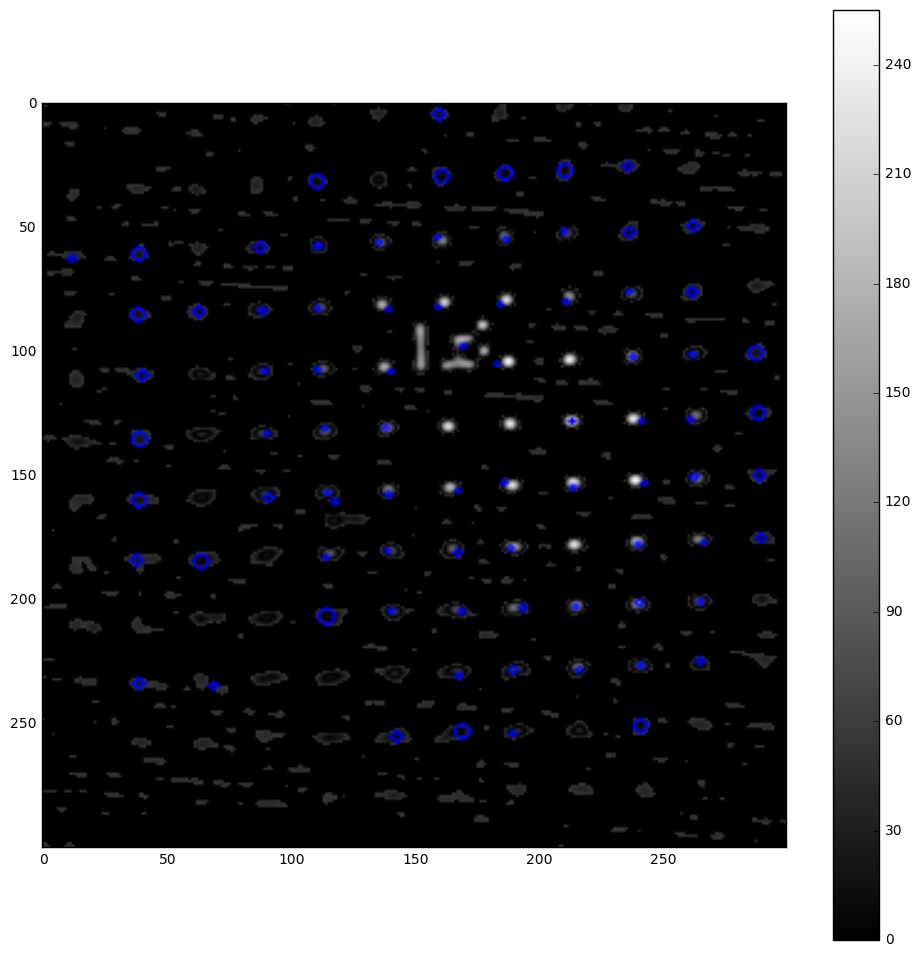

In [252]:
laplace_8bit = rescale_to_8_bit_grayscale(filtered_laplacian)
# show_image(laplace_8bit)
print np.amax(laplace_8bit),np.amin(laplace_8bit)

####
# blob detector params
####

blob_params = cv2.SimpleBlobDetector_Params()

blob_params.minThreshold = 5
blob_params.maxThreshold = 300
# Filter by area
blob_params.filterByArea = True
blob_params.minArea = 0
blob_params.maxArea = 30
#Filter by Circularity
blob_params.filterByCircularity = True
blob_params.minCircularity = 0.1

#Filter by Converxity
blob_params.filterByConvexity = True
blob_params.minConvexity = 0.6

# Filter by Inertia
blob_params.filterByInertia = True
blob_params.minInertiaRatio = 0.3


detector = cv2.SimpleBlobDetector_create(blob_params)
keypoints = detector.detect(laplace_8bit)
im_with_keypoints = cv2.drawKeypoints(laplace_8bit,keypoints,np.array([]),
                                      (0,0,255),cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show_image(im_with_keypoints,size = 12)
# cv2.imshow("Keypoints",im_with_keypoints)

In [253]:
len(keypoints) ## 81 keypoints in this image. ### we should make a filter that circumvents and detects debris on the diamond
## the other image has 85 keypoints.

81

this is the average slope:  0.0238878253586
this is the average grid distance 25.0263914067
8 6


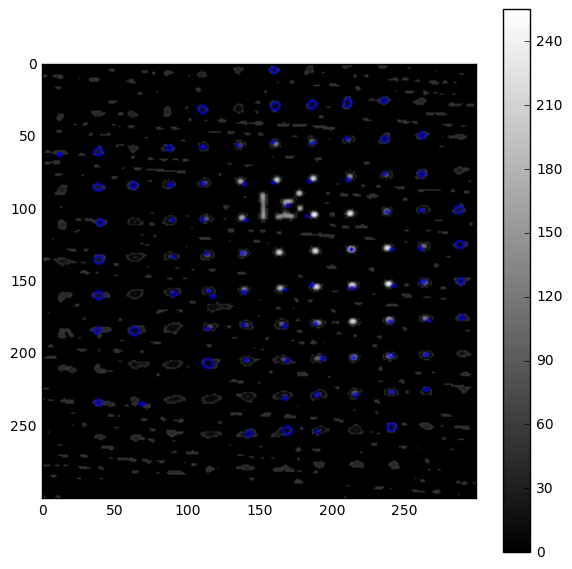

In [254]:
def detect_1D_clusters(array1d,distance = 13,verbose = False):
    """
    finds clustering in a 1d array. returns points within the clusters.
    This function is mainly used for grid detection and assumes a few parameters 
    Only clusters of a length of more than 6 values are taken in.
    Clusters are identified by differences in value of more than 10 (kwarg distance). 
    Distance is given in units of array indices of the original image.
    """
    x_cluster_distance = np.round(np.abs(np.diff(np.sort(array1d))))    
    ### try to identify chains of markers with a length > 6
    x_cluster_diff = np.diff(np.array(range(len(x_cluster_distance)))[x_cluster_distance>distance]) 
    
    clusters_to_be_fitted = x_cluster_diff>=6
    cluster_indices = np.cumsum(x_cluster_diff)[clusters_to_be_fitted]
    if verbose:
        print x_cluster_distance
        print x_cluster_diff
        print cluster_indices
    xcentres = np.sort(array1d)[cluster_indices] ### get some indication for the desired x value where we start the fit.
    
    return xcentres
    
def fit_1D_lines_to_clusters(x,y,cluster_positions):
    """
    Input: x coordinates of all keypoints
            y coordinates of all keypoints
            cluster positions along y
            Note that x and y might be interchanged to fit vertical or horizontal lines in the original image
    Output:
        fit_offsets; list containing the offsets
        fit_slopes; list containing the slopes
        fit_results; list containing the fit dictionaries
    """
    fit_offsets = [] 
    fit_slopes = []
    fit_results = []
    for x_centre in cluster_positions:
        x_filt = (x > x_centre-10) & (x<x_centre+10) ## get all relevant values
        key_xs_filt = x[x_filt]
        key_ys_filt = y[x_filt]
        
        
        ### fit a line to the estimated keypoints we took a slice along x so y becomes the effective x-coordinate for this fit.
        p0,fitfunc,fitfunc_str = common.fit_line(np.average(key_xs_filt),0.0)
        fit_result = fit.fit1d(key_ys_filt,key_xs_filt,None,p0= p0,fitfunc=fitfunc,do_print=False,ret=True,fixed=[])
        
        fit_offsets.append(fit_result['params_dict']['a']);fit_slopes.append(fit_result['params_dict']['b'])
        fit_results.append(fit_result)
        
    return fit_offsets,fit_slopes,fit_results

def estimate_grid_from_keypts(im,keypoints,plot_fitted_lines = False,verbose = False):
    """
    tries to fit a rectangular grid to the estimated keypoints
    currently only works for relatively small angular deviations modulo 90 degrees
    A grid at 45 degree rotation is the wrost case scenario
    returns angle, pitch and offset from the origin x0
    """
    ## extract all x and y values
    key_xs = []
    key_ys = []
    for k in keypoints:
        (x,y) = k.pt
        key_xs.append(x);key_ys.append(y)
    key_xs = np.array(key_xs); key_ys = np.array(key_ys)
    
    ### now take several x-slices and fit a line to the given keypoints
    
    ### we first cluster the keypoint_xcoords by sorting them and looking for the largest gaps. 
    ### (after all the markers are expected to be almost on a straightline
    xcentres = detect_1D_clusters(key_xs,verbose = verbose)
    ycentres = detect_1D_clusters(key_ys,verbose = verbose)
    x_offset,x_slope,x_fits = fit_1D_lines_to_clusters(key_xs,key_ys,xcentres)
    y_offset,y_slope,y_fits = fit_1D_lines_to_clusters(key_ys,key_xs,ycentres)
    
    if plot_fitted_lines:
        for xcent,fit_result in zip(xcentres,x_fits):
            ymin = np.amin(key_ys).astype(np.uint16)
            ymax = np.amax(key_ys).astype(np.uint16)
            cv2.line(im,(fit_result['fitfunc'](ymin).astype(np.uint16),ymin),
                               (fit_result['fitfunc'](ymax).astype(np.uint16),ymax),(255,0,255),1)
            
        for ycent,fit_result in zip(ycentres,y_fits):
            ymin = np.amin(key_xs).astype(np.uint16)
            ymax = np.amax(key_xs).astype(np.uint16)
            cv2.line(im,(ymin,fit_result['fitfunc'](ymin).astype(np.uint16)),
                               (ymax,fit_result['fitfunc'](ymax).astype(np.uint16)),(0,255,0),1)
    
    
    ### average over all the slopes:
    print "this is the average slope: ", np.average(np.append(x_slope,-1*y_slope))
    avg_slope = np.average(np.append(x_slope,-1*y_slope))
    grid_distances = np.append(np.diff(y_offset),np.diff(x_offset))
    avg_distance = np.average(grid_distances[grid_distances < 30]) ### one could do something smarter here...
    print "this is the average grid distance", avg_distance ## assume a typical distance smaller than 30 indices
    
    
    ### estimate origin by choosing the best fit (smallest error) and from there the point which is closest to the fitted grid.
    err_dict_offset = []
    err_dict_slope = []
    print len(x_fits),len(y_fits)
    all_fits = x_fits +y_fits
    for fit in all_fits:
        err_dict_offset.append(fit['error_dict']['a'])
        err_dict_slope.append(fit['error_dict']['b'])
    
    err_dict_offset = np.array(err_dict_offset);err_dict_slope = np.array(err_dict_slope)
    total_error = err_dict_offset + err_dict_slope # simple addition of the uncertainties to gain some fit fitness
    best_fit = all_fits[np.argmin(total_error)]
    best_fit_is_x_fit = False
    if np.argmin(total_error) < len(x_fits):
        best_fit_is_x_fit = True
    x0 = best_fit['x'][0]; y0 = best_fit['y'][0]
    
    return avg_slope,avg_distance,x0,y0
    


avg_slope,avg_distance,x0,y0 = estimate_grid_from_keypts(im_with_keypoints,keypoints,plot_fitted_lines = False)

show_image(im_with_keypoints)

In [255]:
### we now turn to stamp out the grid at the right places from the image such that we can identify the big marker.

def get_grid_crossing_pts(x0,y0,avg_slope,avg_distance):
    grid_positions = np.array(range(-10,10,1))
    grid_angle = np.arctan(avg_slope)
    
    ## generate crossing points for 1 horizontal line
    x_pos1 = grid_positions*avg_distance*np.cos(grid_angle)+x0
    y_pos1 = grid_positions*avg_distance*np.sin(grid_angle)+y0
    xy_pos = []
    ### we now loop over the crossing points of this horizontal line and generate all crossing points over the entire image
    for x,y in zip(x_pos1,y_pos1):
        xs = -grid_positions*avg_distance*np.sin(grid_angle)+x
        ys = grid_positions*avg_distance*np.cos(grid_angle)+y
        xy = xs+1j*ys ### make this numbers imaginary for ease of handling.
        xy_pos.extend(xy)
        
    x_filt = (np.array(xy_pos).real > 0) & (np.array(xy_pos).real < 300)
    y_filt = (np.array(xy_pos).imag > 0) & (np.array(xy_pos).imag < 300)
    xy_filt = np.logical_and(x_filt,y_filt)
    xy_pos = np.array(xy_pos)[xy_filt]
    return xy_pos

def get_distance_of_keypts_to_grid(keypts,x0,y0,avg_slope,avg_distance):
    pass

all_marker_pts = get_grid_crossing_pts(x0,y0,avg_slope,avg_distance)

def plot_marker_grid_onto_im(im,all_marker_pts,marker_size):
    """
    To be written
    """
    marker_pos = np.zeros(np.shape(im))
    [indices_x,indices_y] = np.indices(np.shape(im))
    some_ones = np.ones(np.shape(im))
    for mx,my in zip(all_marker_pts.real,all_marker_pts.imag):
        marker_pos = marker_pos + some_ones*(indices_x < mx + marker_size)*(indices_x > mx - marker_size)*(indices_y > my - marker_size)*(indices_y < my + marker_size)
    show_image(im)
    show_image(im*(marker_pos-1)*(-1))
        

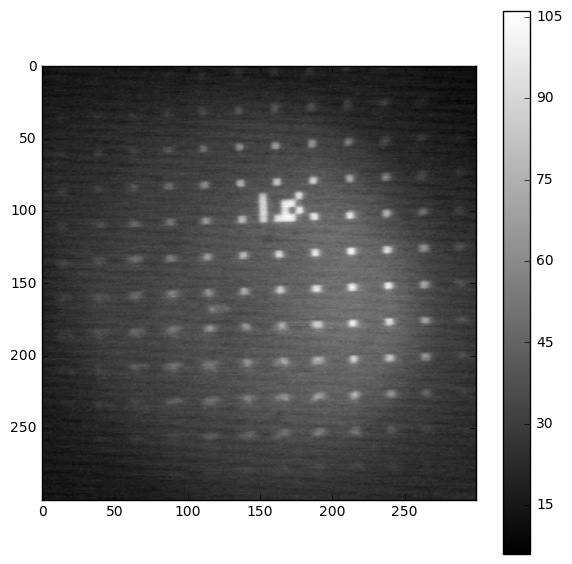

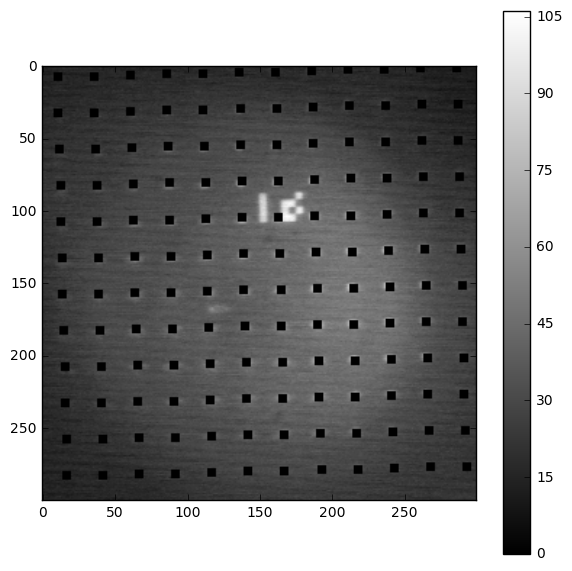

In [256]:
plot_marker_grid_onto_im(array_prepared,all_marker_pts,3)